## 1. Setup and Imports

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. Dataset Exploration

In [2]:
BASE_PATH = "Dataset/Infection Segmentation Data/Infection Segmentation Data"
TRAIN_COVID_PATH = os.path.join(BASE_PATH, "Train/COVID-19")

print("Contents of COVID-19 train directory:")
print(os.listdir(TRAIN_COVID_PATH))

Contents of COVID-19 train directory:
['images', 'infection masks', 'lung masks']


In [3]:
images_dir = os.path.join(TRAIN_COVID_PATH, "images")
masks_dir = os.path.join(TRAIN_COVID_PATH, "infection masks")

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.png')])

print(f"Number of training images: {len(image_files)}")
print(f"Number of infection masks: {len(mask_files)}")

Number of training images: 1864
Number of infection masks: 1864

Sample filenames: ['covid_1.png', 'covid_100.png', 'covid_1000.png', 'covid_1001.png', 'covid_1002.png']


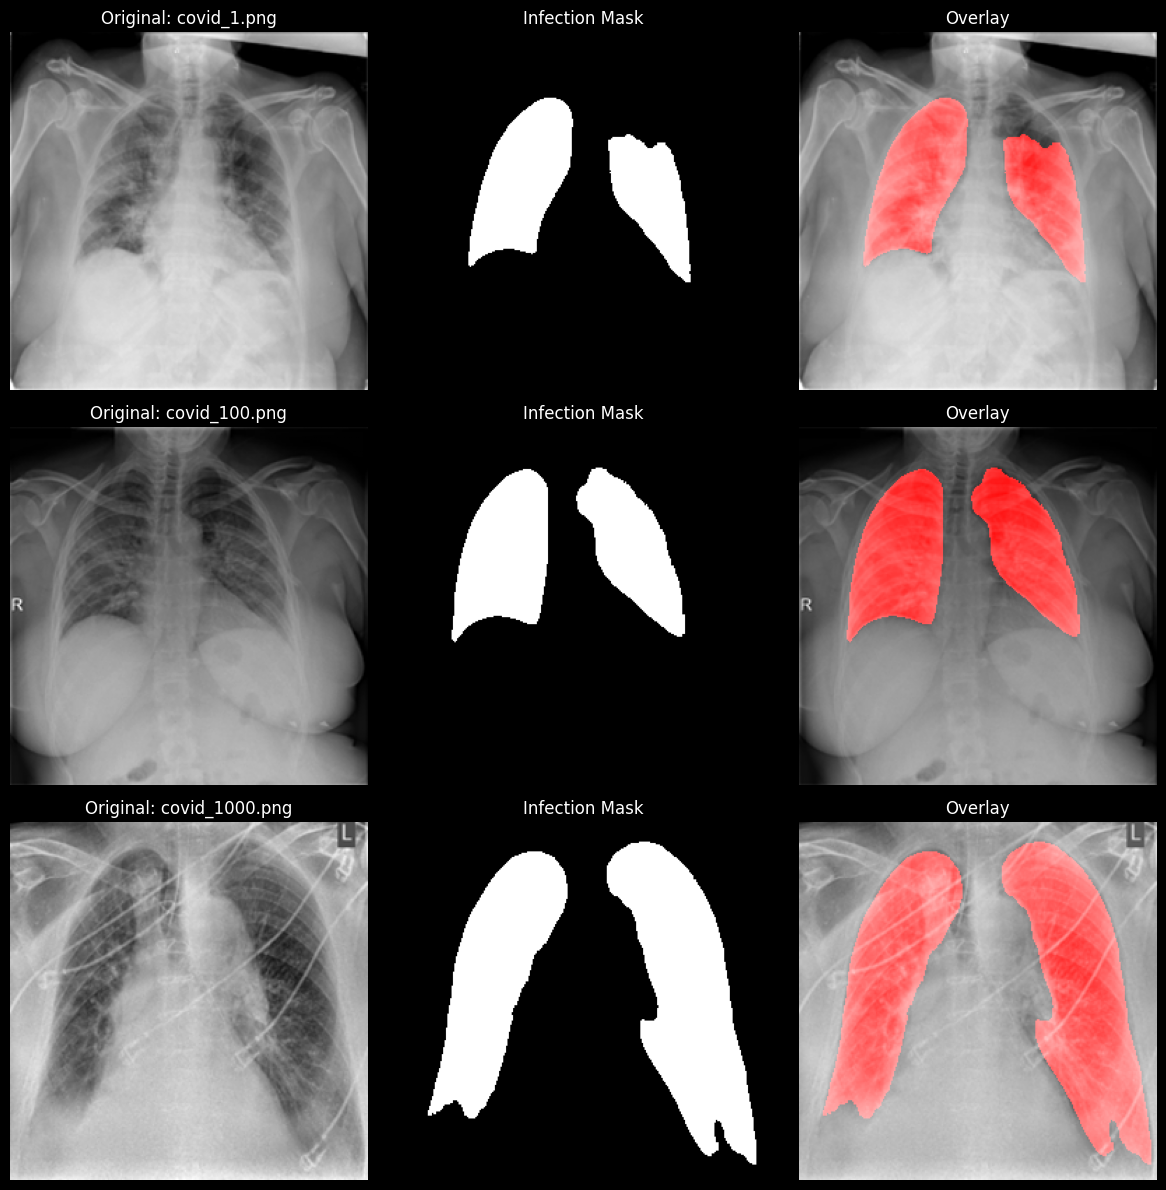

In [4]:
def visualize_samples(images_dir, masks_dir, num_samples=3):
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    sample_files = image_files[:num_samples]
    
    for i, fname in enumerate(sample_files):
        img = Image.open(os.path.join(images_dir, fname)).convert('L')
        mask = Image.open(os.path.join(masks_dir, fname)).convert('L')
        
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f'Original: {fname}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Infection Mask')
        axes[i, 1].axis('off')
        
        # Overlay
        img_arr = np.array(img)
        mask_arr = np.array(mask)
        overlay = np.stack([img_arr, img_arr, img_arr], axis=-1)
        overlay[mask_arr > 0, 0] = 255
        
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(images_dir, masks_dir)

## 3. Dataset Class

In [5]:
class CovidSegmentationDataset(Dataset):
    def __init__(self, root_dir, split='Train', transform=None, mask_transform=None):
        self.image_dir = os.path.join(root_dir, split, 'COVID-19', 'images')
        self.mask_dir = os.path.join(root_dir, split, 'COVID-19', 'infection masks')
        
        self.image_names = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.png')])
        
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Binarize mask
        mask = (mask > 0.5).float()
        
        return image, mask

In [6]:
IMG_SIZE = 128

image_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = CovidSegmentationDataset(
    root_dir=BASE_PATH,
    split='Train',
    transform=image_transform,
    mask_transform=mask_transform
)

val_dataset = CovidSegmentationDataset(
    root_dir=BASE_PATH,
    split='Val',
    transform=image_transform,
    mask_transform=mask_transform
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 1864
Validation samples: 466


In [7]:
# Create DataLoaders
BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Test loading
images, masks = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Mask batch shape: {masks.shape}")

Image batch shape: torch.Size([8, 1, 128, 128])
Mask batch shape: torch.Size([8, 1, 128, 128])


## 4. U-Net Model

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[16, 32, 64, 128]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        
        # Decoder
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx // 2]

            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)

            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx + 1](x)

        return torch.sigmoid(self.final_conv(x))

In [9]:
# Test model
model = UNet(in_channels=1, out_channels=1).to(device)
x = torch.randn(2, 1, IMG_SIZE, IMG_SIZE).to(device)
out = model(x)
print(f"Input: {x.shape} -> Output: {out.shape}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Input: torch.Size([2, 1, 128, 128]) -> Output: torch.Size([2, 1, 128, 128])
Total parameters: 1,942,289


## 5. Loss Function and Metrics

In [10]:
def dice_score(pred, target, smooth=1e-6):
    """Calculate Dice Score."""
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()


class DiceBCELoss(nn.Module):
    """Combined Dice and BCE Loss."""
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        
        # Dice loss
        smooth = 1e-6
        intersection = (pred * target).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        
        return bce_loss + dice_loss

## 6. Training

In [11]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_dice = 0
    
    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_dice += dice_score(outputs, masks)
    
    return total_loss / len(loader), total_dice / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            total_dice += dice_score(outputs, masks)
    
    return total_loss / len(loader), total_dice / len(loader)

In [12]:
# Training setup
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4

model = UNet(in_channels=1, out_channels=1).to(device)
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training history
history = {
    'train_loss': [], 'val_loss': [],
    'train_dice': [], 'val_dice': []
}

In [13]:
# Training loop
best_val_dice = 0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 30)
    
    train_loss, train_dice = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    
    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
    
    # Save best model
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model!")


Epoch 1/5
------------------------------


Validation: 100%|██████████| 59/59 [00:07<00:00,  7.63it/s]


Train Loss: 1.3095, Train Dice: 0.4574
Val Loss: 1.1932, Val Dice: 0.5679
Saved best model!

Epoch 2/5
------------------------------


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.71it/s]


Train Loss: 1.1437, Train Dice: 0.6109
Val Loss: 1.0931, Val Dice: 0.6549
Saved best model!

Epoch 3/5
------------------------------


Validation: 100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


Train Loss: 1.0603, Train Dice: 0.6689
Val Loss: 1.0205, Val Dice: 0.6884
Saved best model!

Epoch 4/5
------------------------------


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.95it/s]


Train Loss: 0.9774, Train Dice: 0.7161
Val Loss: 0.9364, Val Dice: 0.7315
Saved best model!

Epoch 5/5
------------------------------


Validation: 100%|██████████| 59/59 [00:06<00:00,  9.68it/s]


Train Loss: 0.9049, Train Dice: 0.7454
Val Loss: 0.8676, Val Dice: 0.7729
Saved best model!


## 7. Evaluation and Visualization

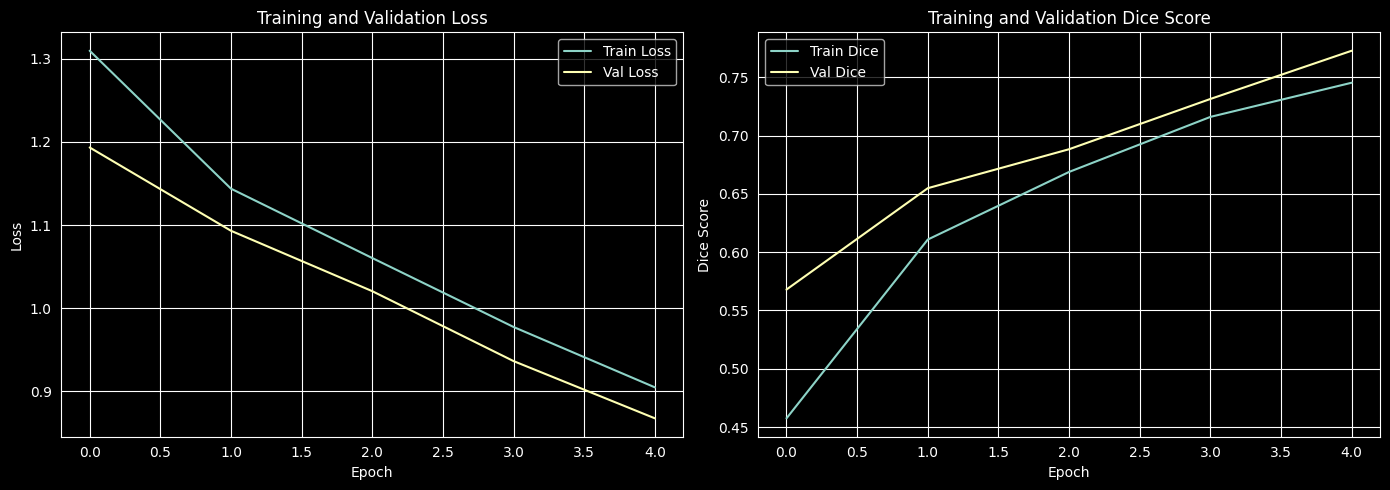

In [14]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

axes[1].plot(history['train_dice'], label='Train Dice')
axes[1].plot(history['val_dice'], label='Val Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Training and Validation Dice Score')
axes[1].legend()

plt.tight_layout()
plt.show()

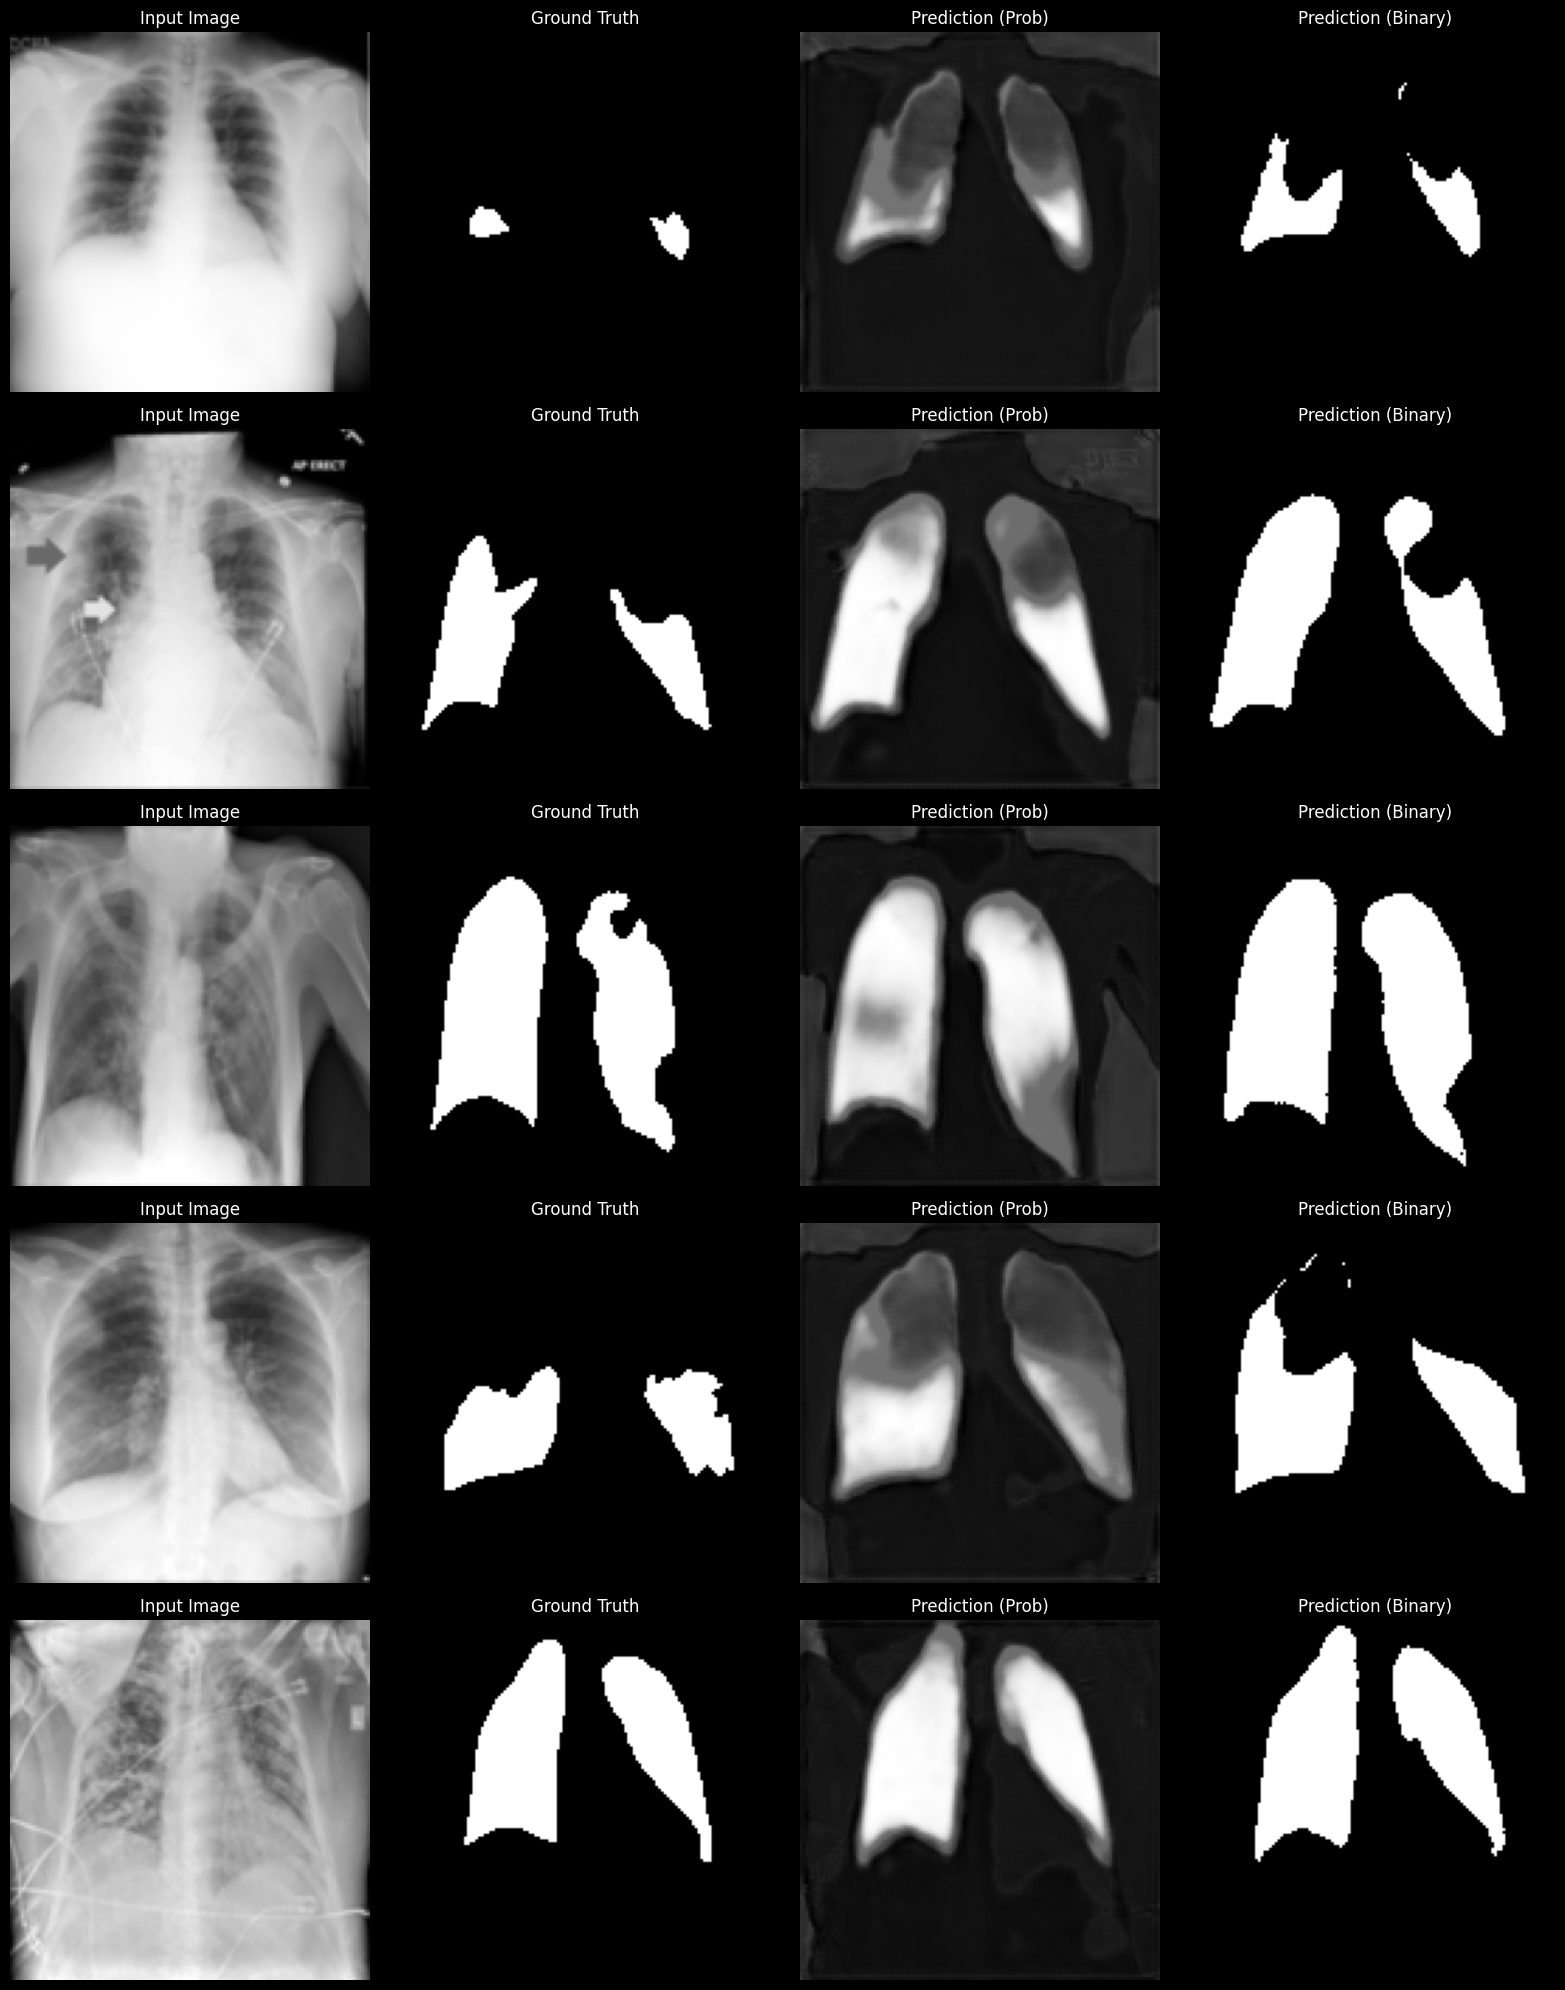

In [15]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

def visualize_predictions(model, dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device))
            pred = pred.cpu().squeeze().numpy()
        
        image = image.squeeze().numpy()
        mask = mask.squeeze().numpy()
        pred_binary = (pred > 0.5).astype(np.float32)
        
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('Prediction (Prob)')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(pred_binary, cmap='gray')
        axes[i, 3].set_title('Prediction (Binary)')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset)

## 8. Test Set Evaluation

In [16]:
# Create test dataset and evaluate
test_dataset = CovidSegmentationDataset(
    root_dir=BASE_PATH,
    split='Test',
    transform=image_transform,
    mask_transform=mask_transform
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Test samples: {len(test_dataset)}")

test_loss, test_dice = validate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Dice Score: {test_dice:.4f}")

Test samples: 583


Validation: 100%|██████████| 73/73 [00:08<00:00,  9.00it/s]


Test Loss: 0.8748
Test Dice Score: 0.7640


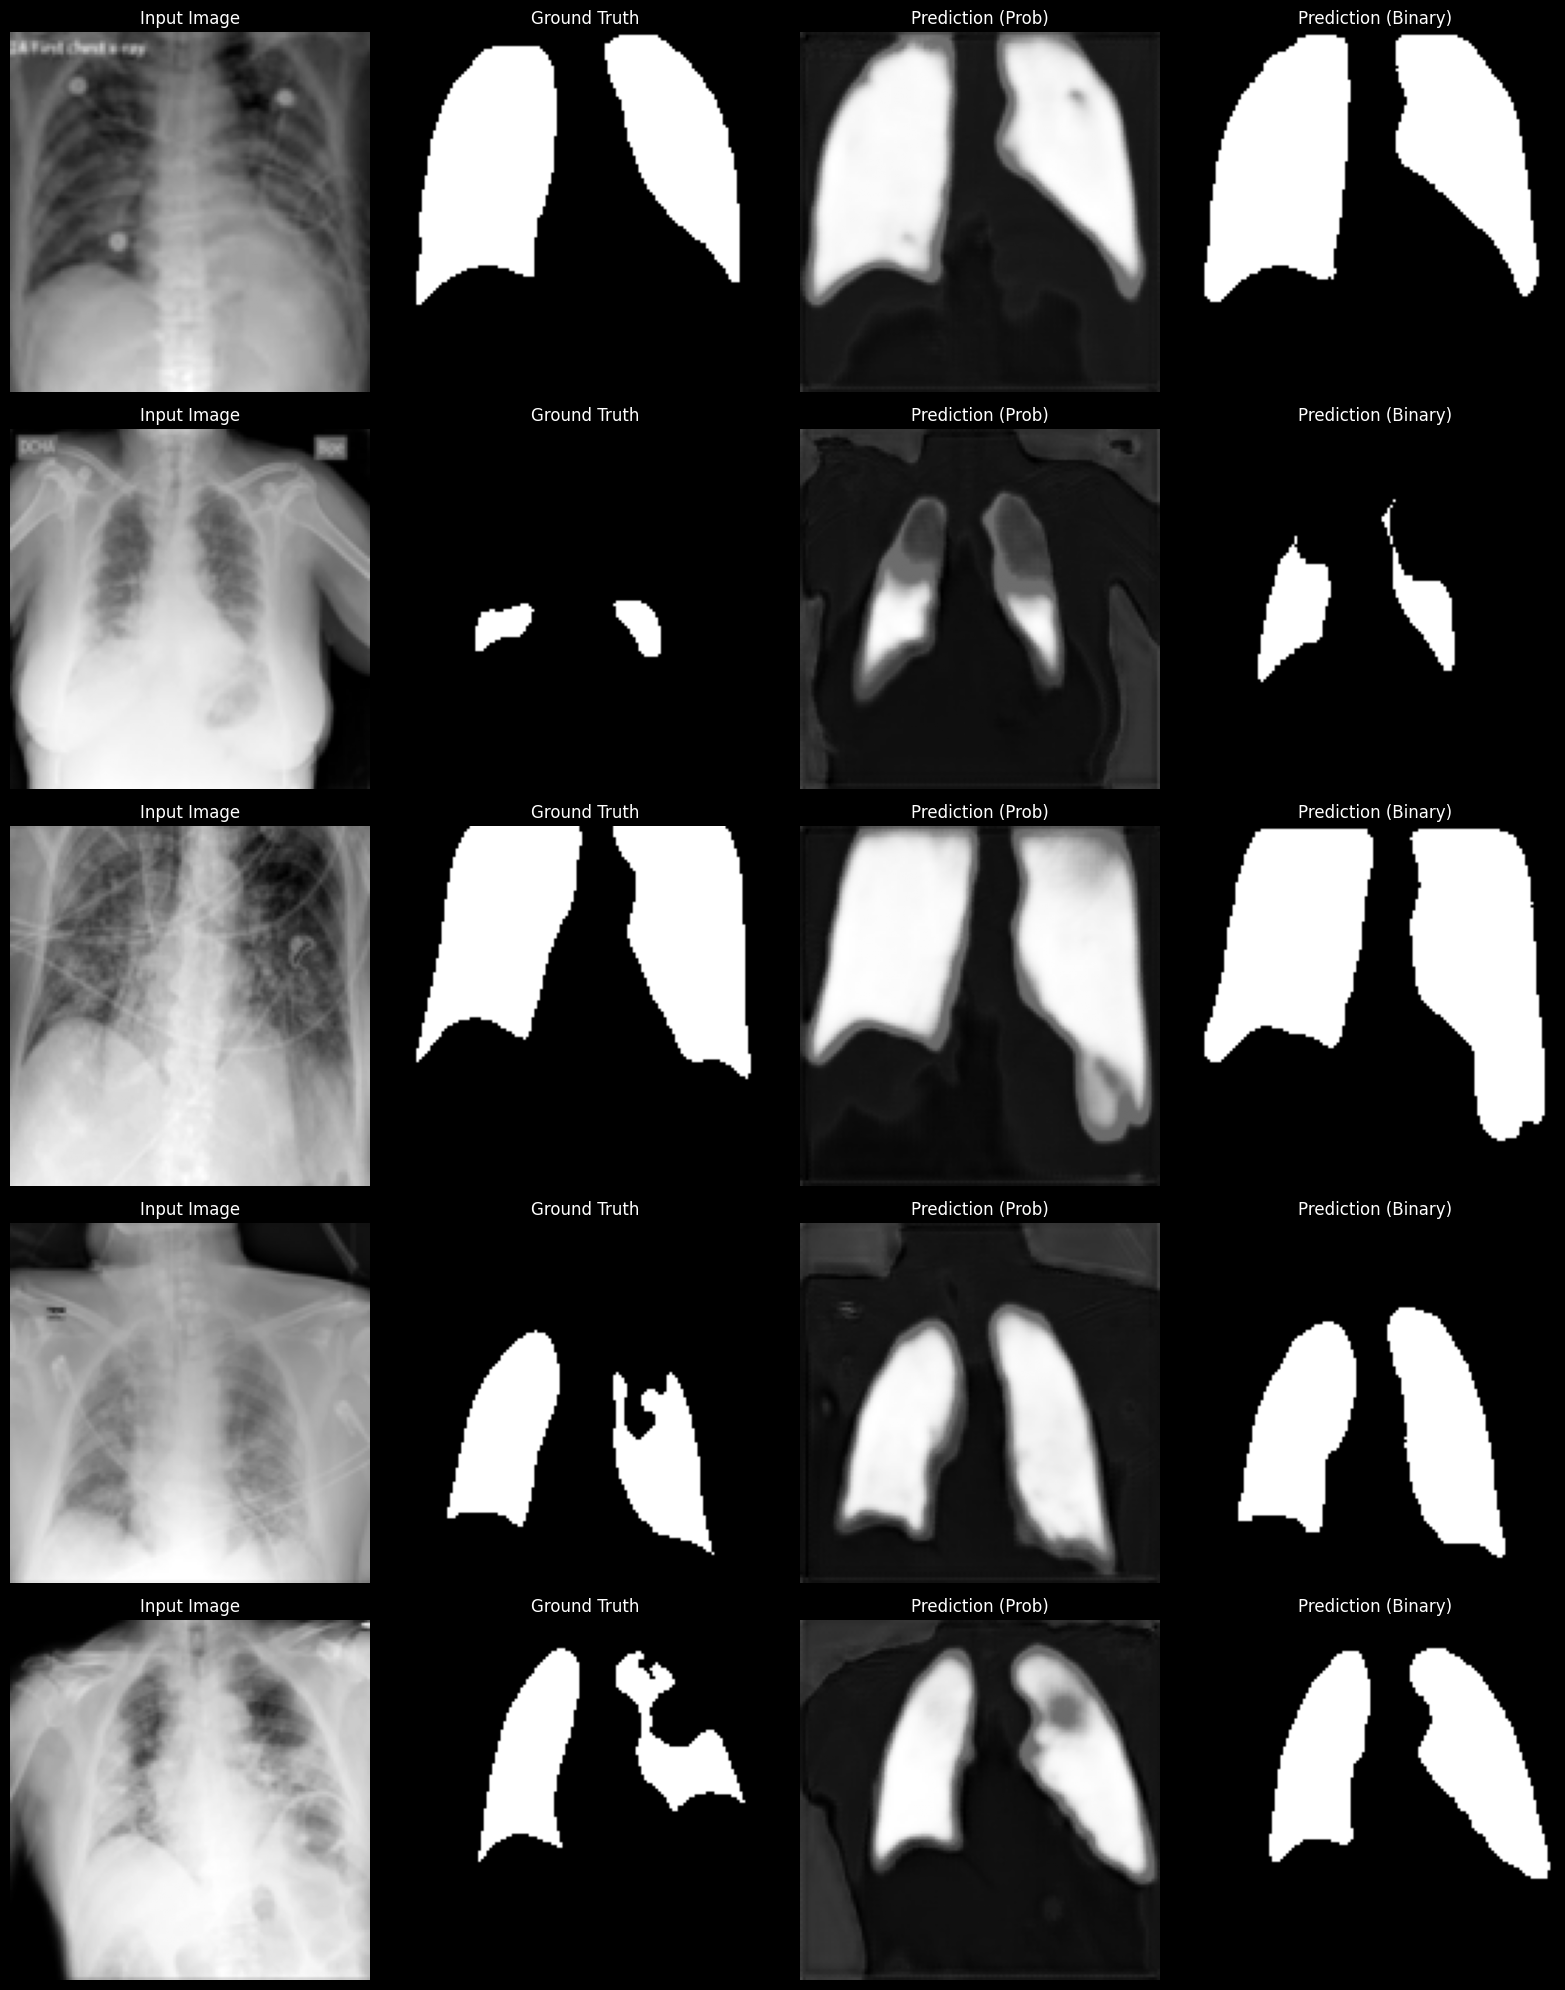

In [17]:
# Visualize test predictions
visualize_predictions(model, test_dataset)